## Week 4, Lab 2: Predicting Chronic Kidney Disease in Patients
> Author: Matt Brems

We can sketch out the data science process as follows:
1. Define the problem.
2. Obtain the data.
3. Explore the data.
4. Model the data.
5. Evaluate the model.
6. Answer the problem.

In this lab, we're going to focus on steps exploring data, building models and evaluating the models we build.

There are three links you may find important:
- [A set of chronic kidney disease (CKD) data and other biological factors](./chronic_kidney_disease_full.csv).
- [The CKD data dictionary](./chronic_kidney_disease_header.txt).
- [An article comparing the use of k-nearest neighbors and support vector machines on predicting CKD](./chronic_kidney_disease.pdf).

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import math
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, \
ConfusionMatrixDisplay, roc_auc_score

## Step 1: Define the problem.

Suppose you're working for Mayo Clinic, widely recognized to be the top hospital in the United States. In your work, you've overheard nurses and doctors discuss test results, then arrive at a conclusion as to whether or not someone has developed a particular disease or condition. For example, you might overhear something like:

> **Nurse**: Male 57 year-old patient presents with severe chest pain. FDP _(short for fibrin degradation product)_ was elevated at 13. We did an echo _(echocardiogram)_ and it was inconclusive.

> **Doctor**: What was his interarm BP? _(blood pressure)_

> **Nurse**: Systolic was 140 on the right; 110 on the left.

> **Doctor**: It's an aortic dissection! Get to the OR _(operating room)_ now!

> _(intense music playing)_

In this fictitious  scenario, you might imagine the doctor going through a series of steps like a [flowchart](https://en.wikipedia.org/wiki/Flowchart), or a series of if-this-then-that steps to diagnose a patient. The first steps made the doctor ask what the interarm blood pressure was. Because interarm blood pressure took on the values it took on, the doctor diagnosed the patient with an aortic dissection.

Your goal, as a research biostatistical data scientist at the nation's top hospital, is to develop a medical test that can improve upon our current diagnosis system for [chronic kidney disease (CKD)](https://www.mayoclinic.org/diseases-conditions/chronic-kidney-disease/symptoms-causes/syc-20354521).

**Real-world problem**: Develop a medical diagnosis test that is better than our current diagnosis system for CKD.

**Data science problem**: Develop a medical diagnosis test that reduces both the number of false positives and the number of false negatives.

---

## Step 2: Obtain the data.

### 1. Read in the data.

In [2]:
df = pd.read_csv('./chronic_kidney_disease_full.csv')

In [3]:
print(df.shape)
df.head()

(400, 25)


,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


In [4]:
# Check data for top 5 rows
df.head(5).T

,0,1,2,3,4
age,48.0,7.0,62.0,48.0,51.0
bp,80.0,50.0,80.0,70.0,80.0
sg,1.02,1.02,1.01,1.005,1.01
al,1.0,4.0,2.0,4.0,2.0
su,0.0,0.0,3.0,0.0,0.0
rbc,NaN,NaN,normal,normal,normal
pc,normal,normal,normal,abnormal,normal
pcc,notpresent,notpresent,notpresent,present,notpresent
ba,notpresent,notpresent,notpresent,notpresent,notpresent
bgr,121.0,NaN,423.0,117.0,106.0


### 2. Check out the data dictionary. What are a few features or relationships you might be interested in checking out?

Answer:
- age: Elders would have higher chance to get kidney disease than others. 
- sc: Serum creatinine that included in urine test for CKD
- bu: CKD could affect the blood in urine. 

[Cite](https://www.nhs.uk/conditions/kidney-disease/diagnosis/#:~:text=The%20main%20test%20for%20kidney,to%20filter%20in%20a%20minute.)

---

## Step 3: Explore the data.

### 3. How much of the data is missing from each column?

In [5]:
# Check missing values

# Create variables for missing values
missing_n = df.isnull().sum().sort_values(ascending=False)
missing_percent = df.isnull().sum().sort_values(ascending=False) / df.shape[0] * 100

# Assign to dataframe
missing_df = pd.DataFrame({'n_missing': missing_n, 'percent_missing': missing_percent})
missing_df
## There are more than 10 variables that have missing values more than 10%
## rbc variable is most missed values variable, which has 152 missing values.

,n_missing,percent_missing
rbc,152,38.00
rbcc,131,32.75
wbcc,106,26.50
pot,88,22.00
sod,87,21.75
pcv,71,17.75
pc,65,16.25
hemo,52,13.00
su,49,12.25
sg,47,11.75


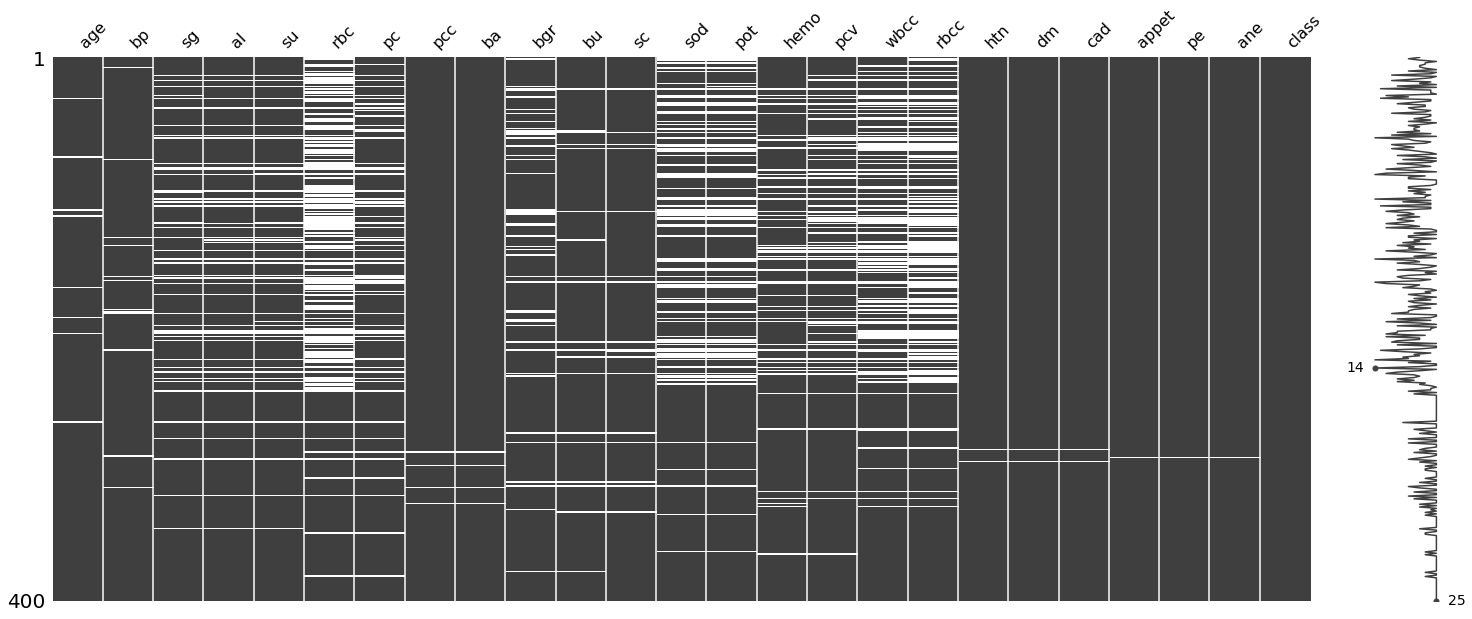

In [6]:
# Identify pattern of missing values
msno.matrix(df);

# Some patterns of missing values can be observed by the chart below.
# sg, al, and su tend to have missing values occurrence in the same time
# sod, pot also have same missing spots
# wbcc and rbcc have same missing spots as well. 

### 4. Suppose that I dropped every row that contained at least one missing value. (In the context of analysis with missing data, we call this a "complete case analysis," because we keep only the complete cases!) How many rows would remain in our dataframe? What are at least two downsides to doing this?

In [7]:
# Count number of rows after dropping missing values
print(f'Rows before dropping: {df.shape[0]}\nRows after dropping: {df.dropna().shape[0]}')

Rows before dropping: 400
Rows after dropping: 158


Answer: 
If we dropevery row that contain missing values, only 158 rows will remain in the dataframe

Downsides of dropping:
- More than 50% of data will be dropped and the remaining data are not sufficient to train a model.
- The dropped data still have lot of useful features that we could use to predict a model.

### 5. Thinking critically about how our data were gathered, it's likely that these records were gathered by doctors and nurses. Brainstorm three potential areas (in addition to the missing data we've already discussed) where this data might be inaccurate or imprecise.

Answer:

As data have a lot of missing values, the data reliability must be low. There are patterns of missing values spotted on groups of variables which could imply that variables or tests of patients health collected on different labs
and patients might skip the test.

The group of missing values are named below
- sg, al, and su
- sod and pot
- wbcc and rbcc

---

## Step 4: Model the data.

### 6. Suppose that I want to construct a model where no person who has chronic kidney disease (CKD) will ever be told that they do not have CKD. What (very simple, no machine learning needed) model can I create that will never tell a person with CKD that they do not have CKD?

> Hint: Don't think about `statsmodels` or `scikit-learn` here.

Answer: The model that will never tell a person with CKD that they don't have CKD is model with 100% sensitivity.
Which means the model will tell every person that has CKD. And could lead decreasing specificity and accuracy of our model.

### 7. In problem 6, what common classification metric did we optimize for? Did we minimize false positives or negatives?

Answer: We minimized false negatives because we predicted every person has CKD which could turn to be only 2 result.
1. Predicted CKD and patient has CKD also called true positives
2. Predicted CKD and patient has no CKD called false positives

Which means the negatives or no CKD were not predicted and falsely predicted is minimized to be 0.


### 8. Thinking ethically, what is at least one disadvantage to the model you described in problem 6?

Answer: 
- The ethical disadvantage is the persons with no CKD but predicted to have CKD could change daily behavior.
    - For example, the persons could have too anxiety to live as their usual.
- The persons would take treatment that they do not need to take and get too many chemical medicines.


### 9. Suppose that I want to construct a model where a person who does not have CKD will ever be told that they do have CKD. What (very simple, no machine learning needed) model can I create that will accomplish this?

Answer: The model that can accomplish this situation is to tell every person that they do not have CKD. Technically, we create model that has 100% of specificity.

### 10. In problem 9, what common classification metric did we optimize for? Did we minimize false positives or negatives?

Answer: 
- As from question number 9 model, we minimized false positives because we are going to tell every person that they don't have CKD (which is negative prediction).
- And the model will never tell persons that they have CKD which leads to no positive predicted and no false positives occurrences.

### 11. Thinking ethically, what is at least one disadvantage to the model you described in problem 9?

Answer:
- Patients who really have CKD will not be treated properly that could make higher mortality rate.
- Patients might know that they have CKD in the future. It's too late to be treated or costed higher than a treatment should be. 

### 12. Construct a logistic regression model in `sklearn` predicting class from the other variables. You may scale, select/drop, and engineer features as you wish - build a good model! Make sure, however, that you include at least one categorical/dummy feature and at least one quantitative feature.

> Hint: Remember to do a train/test split!

### Cleaning Data

In [8]:
# Check missing values
# Create dataframe of missing by target variable 
missing_class = df.drop('class', axis=1).isna().groupby(df['class']).sum().T

# Calculate % missing values by all observations by class
missing_class['ckd_percent'] = round(missing_class['ckd'] / df['class'].value_counts()['ckd'], 2)
missing_class['notckd_percent'] = round(missing_class['notckd'] / df['class'].value_counts()['notckd'], 2)

# Sort data
missing_class.sort_values(by='ckd', ascending=False, inplace=True)

# Add data type to dataframe
missing_class = missing_class.merge(pd.DataFrame({'type': df.dtypes}), left_index=True, right_index=True)
missing_class.reindex(['type', 'ckd', 'notckd', 'ckd_percent', 'notckd_percent'], axis=1)

## As per tabulation, missing values are likly to be in ckd persons that no ckd persons.
## Action can be 
### 1. impute missing values depend on class label but it will cause the information leakage problem.
### 2. impute data by median but create binary dummies (exsiting/missing) to find weather or not
###    missing data can predict class label.

## We decided to use 2nd option which is create binary dummies for some highest missing variables
## and impute missing by median.


,type,ckd,notckd,ckd_percent,notckd_percent
rbc,object,143,9,0.57,0.06
rbcc,float64,124,7,0.50,0.05
wbcc,float64,99,7,0.40,0.05
pot,float64,83,5,0.33,0.03
sod,float64,82,5,0.33,0.03
pcv,float64,67,4,0.27,0.03
pc,object,56,9,0.22,0.06
hemo,float64,46,6,0.18,0.04
su,float64,44,5,0.18,0.03
sg,float64,42,5,0.17,0.03


In [9]:
# Create dummies for missing values (top 5 most missing values)

# Iterate top 5 missing columns to create dummies
for column in missing_class.index[:5]:
    df[column+'_exist'] = df[column].notnull().astype(int)

# Impute missing values by median (only numerical variables)
df.fillna(df.median(), inplace=True)

C:\Users\Chalermchon Wongsopa\AppData\Local\Temp\ipykernel_12384\3101764741.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.fillna(df.median(), inplace=True)


---
### EDA

In [10]:
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,cad,appet,pe,ane,class,rbc_exist,rbcc_exist,wbcc_exist,pot_exist,sod_exist
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,no,good,no,no,ckd,0,1,1,0,0
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,no,good,no,no,ckd,0,0,1,0,0
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,no,poor,no,yes,ckd,1,0,1,0,0
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,no,poor,yes,yes,ckd,1,1,1,1,1
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,no,good,no,no,ckd,1,1,1,0,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         400 non-null    float64
 1   bp          400 non-null    float64
 2   sg          400 non-null    float64
 3   al          400 non-null    float64
 4   su          400 non-null    float64
 5   rbc         248 non-null    object 
 6   pc          335 non-null    object 
 7   pcc         396 non-null    object 
 8   ba          396 non-null    object 
 9   bgr         400 non-null    float64
 10  bu          400 non-null    float64
 11  sc          400 non-null    float64
 12  sod         400 non-null    float64
 13  pot         400 non-null    float64
 14  hemo        400 non-null    float64
 15  pcv         400 non-null    float64
 16  wbcc        400 non-null    float64
 17  rbcc        400 non-null    float64
 18  htn         398 non-null    object 
 19  dm          398 non-null    o

In [12]:
# Describe all numeric variables
df.describe()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,rbc_exist,rbcc_exist,wbcc_exist,pot_exist,sod_exist
count,400.000000,400.000000,400.000000,400.00000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.00000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,51.562500,76.575000,1.017712,0.90000,0.395000,145.062500,56.693000,2.997125,137.631250,4.577250,12.54250,39.082500,8298.500000,4.737750,0.620000,0.672500,0.735000,0.780000,0.782500
std,16.982996,13.489785,0.005434,1.31313,1.040038,75.260774,49.395258,5.628886,9.206332,2.821357,2.71649,8.162245,2529.593814,0.841439,0.485994,0.469889,0.441886,0.414765,0.413062
min,2.000000,50.000000,1.005000,0.00000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.10000,9.000000,2200.000000,2.100000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,42.000000,70.000000,1.015000,0.00000,0.000000,101.000000,27.000000,0.900000,135.000000,4.000000,10.87500,34.000000,6975.000000,4.500000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,55.000000,80.000000,1.020000,0.00000,0.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.65000,40.000000,8000.000000,4.800000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,64.000000,80.000000,1.020000,2.00000,0.000000,150.000000,61.750000,2.725000,141.000000,4.800000,14.62500,44.000000,9400.000000,5.100000,1.000000,1.000000,1.000000,1.000000,1.000000
max,90.000000,180.000000,1.025000,5.00000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.80000,54.000000,26400.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
# Describe all objects
df.select_dtypes('object').describe()

,rbc,pc,pcc,ba,htn,dm,cad,appet,pe,ane,class
count,248,335,396,396,398,398,398,399,399,399,400
unique,2,2,2,2,2,2,2,2,2,2,2
top,normal,normal,notpresent,notpresent,no,no,no,good,no,no,ckd
freq,201,259,354,374,251,261,364,317,323,339,250


In [14]:
# Check balance of target variable
df['class'].value_counts(normalize=True)

## Balance of target variable seem to be acceptable.

ckd       0.625
notckd    0.375
Name: class, dtype: float64

In [15]:
def boxplot_chart(data, features, target):
    """Create boxplot from iterating all given features against a target variable
    data = pd.DataFrame
    x = a target variable
    y = given features"""
    # create subplots by number of x
    rows = math.ceil(len(features) / 4)
    fig, axes = plt.subplots(rows, 4, figsize=(20, rows * 5))
    
    # iterate column name
    for i, feat in enumerate(features): 
        x = i // 4
        y = i % 4
        if len(features) <= 4:
            axs = axes[y]
        else:
            axs = axes[x, y]
        pl = sns.boxplot(
            ax = axs,
            x = target,
            y = feat,
            data = data)

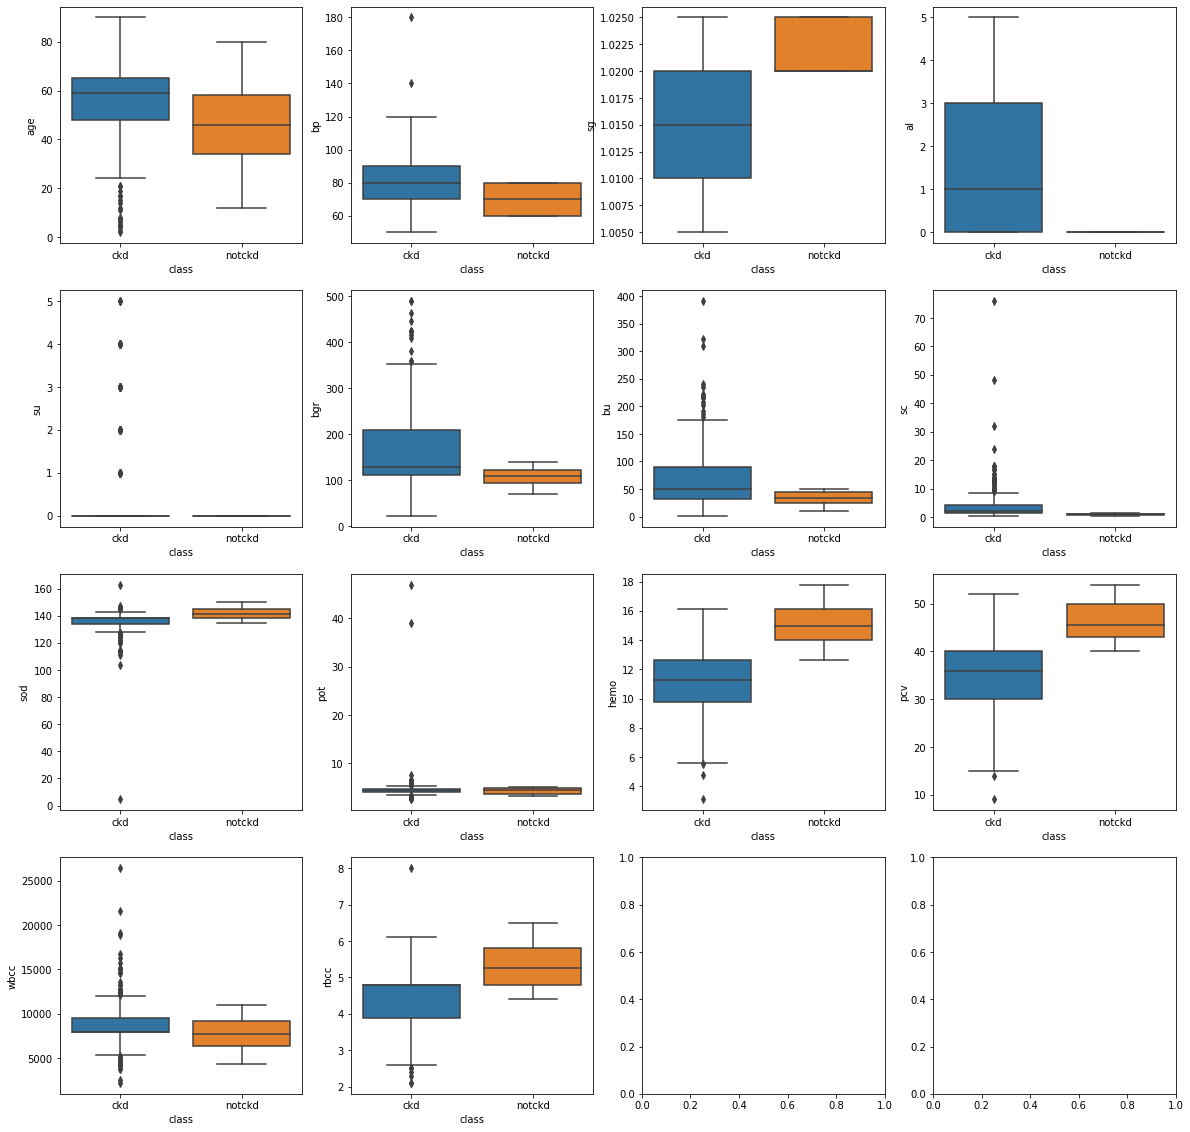

In [16]:
# Plot all numerical variables by class label
boxplot_chart(df, df.select_dtypes(exclude='object').columns[:-5], 'class')

## Boxplots show that some variables has different values between CKD and Non-CKD labels
## e.g. age, bp, sg, al, bgr, bu, hemo, pcv, wbcc, rbcc

In [17]:
df.select_dtypes(object).head()

,rbc,pc,pcc,ba,htn,dm,cad,appet,pe,ane,class
0,NaN,normal,notpresent,notpresent,yes,yes,no,good,no,no,ckd
1,NaN,normal,notpresent,notpresent,no,no,no,good,no,no,ckd
2,normal,normal,notpresent,notpresent,no,yes,no,poor,no,yes,ckd
3,normal,abnormal,present,notpresent,yes,no,no,poor,yes,yes,ckd
4,normal,normal,notpresent,notpresent,no,no,no,good,no,no,ckd


In [18]:
def countplot_chart(data, features, target):
    """Create countplot from iterating all given features cut by target label
    data = pd.DataFrame
    x = given features
    hue = a target variable"""
    # create subplots by number of x
    rows = math.ceil(len(features) / 4)
    fig, axes = plt.subplots(rows, 4, figsize=(20, rows * 5))
    
    # iterate column name
    for i, feat in enumerate(features): 
        x = i // 4
        y = i % 4
        if len(features) <= 4:
            axs = axes[y]
        else:
            axs = axes[x, y]
        pl = sns.countplot(
            ax = axs,
            x = feat,
            data = data,
            hue = target)

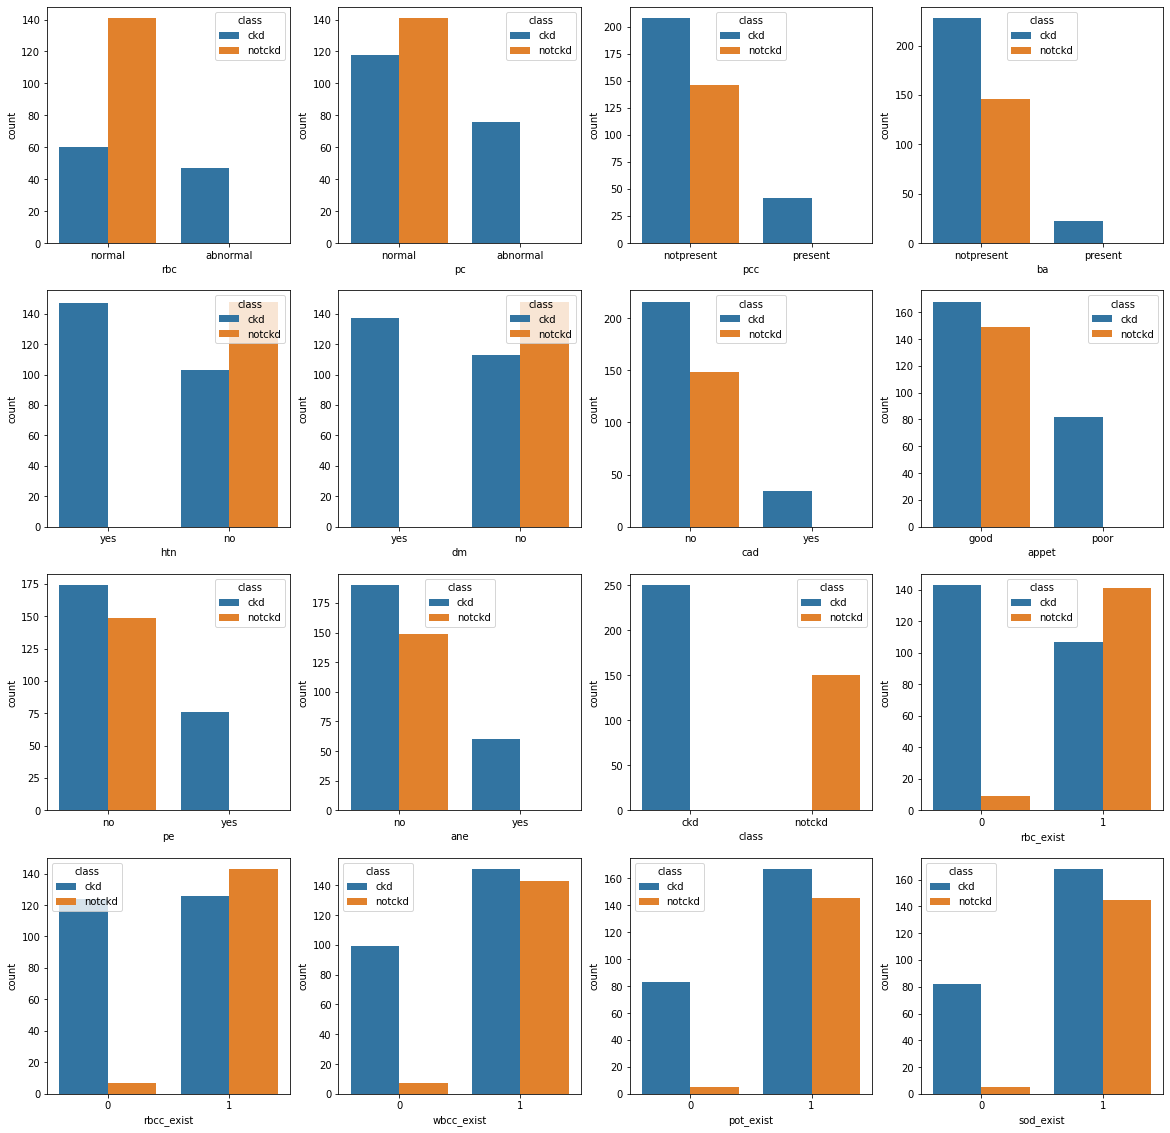

In [19]:
# List categorical variable
cate_list = list(df.select_dtypes(object).columns) + \
                    ['rbc_exist', 'rbcc_exist', 'wbcc_exist','pot_exist', 'sod_exist']

# Create countplots for all categorical variables
countplot_chart(data = df,
                features = cate_list, 
                target = 'class')

# Every categorical variables seem to have different behavior between CKD and Non-CKD

---
### Create model

In [20]:
# Create list of categorical variables
cate_list = list(df.select_dtypes(object).columns)

# Create X, y
features = ['age', 'bp', 'sg', 'al', 'bgr', 'bu', 'hemo', 'pcv', 'wbcc', 'rbcc'] + cate_list[:-1]
X = df[features]
X = pd.get_dummies(X, drop_first=True)
y = (df['class'] == 'ckd').astype(int)

# Split train test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [21]:
# Check split size
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((300, 20), (100, 20), (300,), (100,))

In [22]:
# Instantiate model
logreg = LogisticRegression(penalty='none', max_iter=500, random_state=42)

# Fit training data
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=500, penalty='none', random_state=42)

In [23]:
# Baseline score
df['class'].value_counts(normalize=True).mul(100)

## If we predict all data with dominant label which is CKD,
## The accuracy will be 62.5%

ckd       62.5
notckd    37.5
Name: class, dtype: float64

In [24]:
# Evaluate model
print('Train score:', logreg.score(X_train, y_train))
print('Train cv:', cross_val_score(logreg, X_train, y_train))
print('Train cv mean:', cross_val_score(logreg, X_train, y_train).mean().round(2))
print('-'*50)
print('Test score:', logreg.score(X_test, y_test))

## The model accuracy is better than baseline score and it is very high accuracy.
## Train score is 100% and test score is 98% accuracy rate.
## As from similarlity of train and test scores, it can show that the model is not overfit.

Train score: 1.0
Train cv: [0.93333333 0.98333333 0.98333333 1.         0.98333333]
Train cv mean: 0.98
--------------------------------------------------
Test score: 0.98


In [25]:
# Print classification report

# predict values for test set
y_preds = logreg.predict(X_test)

print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        38
           1       0.98      0.98      0.98        62

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100



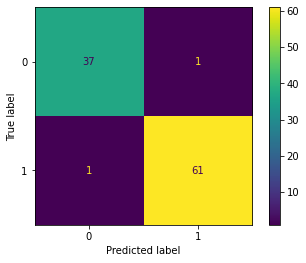

In [26]:
# Confusion matrix

cm = confusion_matrix(y_test, y_preds)

ConfusionMatrixDisplay(confusion_matrix=cm,
                      display_labels=logreg.classes_).plot();

# Only 2 data that incorrectly predicted, one on negative, another on positive.

---

## Step 5: Evaluate the model.

### 13. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your quantitative features.

In [27]:
# Create coef. dataframe
pd.DataFrame({'Feature': X.columns,
              'Coef.': logreg.coef_[0].round(4),
              'exp_Coef.': np.exp(logreg.coef_[0]).round(4)
              }
            ).sort_values(by='Coef.', ascending=False)

,Feature,Coef.,exp_Coef.
3,al,521.6554,3.564879e+226
17,appet_poor,161.1887,1.007804e+70
14,htn_yes,160.9151,7.665286e+69
18,pe_yes,145.7444,1.976893e+63
15,dm_yes,143.6077,2.333676e+62
19,ane_yes,65.4248,2.591855e+28
2,sg,49.1011,2.110329e+21
1,bp,29.4026,5.880157e+12
12,pcc_present,16.3896,1.311886e+07
4,bgr,10.5532,3.829849e+04


In [28]:
# Coefficient interpretation
## al - albumin
## As 1 unit of albumin increase and others is held constant,
## patient is e^(521.65) or 3.5648*e^(226) times likely to have CKD.

### 14. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your categorical/dummy features.

In [29]:
# htn_yes
## If patient has hypertension, 
## patient is e^(160.91) or 7.665*e^(69) times likely to have CKD.

### 15. Despite being a relatively simple model, logistic regression is very widely used in the real world. Why do you think that's the case? Name at least two advantages to using logistic regression as a modeling technique.

Answer: 
- Logistic regression is able to explain relationship between features and targer variables via coefficients that can tell how liklyhood (oods ratio) will be effected by change of features.
- Logistic regression tends to not have overfit problem.

### 16. Does it make sense to generate a confusion matrix on our training data or our test data? Why? Generate it on the proper data.

> Hint: Once you've generated your predicted $y$ values and you have your observed $y$ values, then it will be easy to [generate a confusion matrix using sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

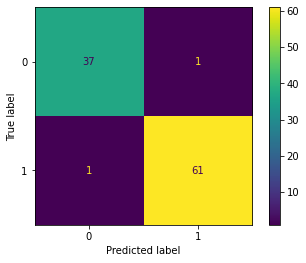

In [30]:
# It does make sense to generate a confusion matrix on test data but not training data.
# Because If the model is overfiting, the confusion matrix of training data will show
# too optimistic performace of overfitting model. 
# So, reading a confusion matrix of test data is better to understand and improve the model.

# Confusion matrix

cm = confusion_matrix(y_test, y_preds)

ConfusionMatrixDisplay(confusion_matrix=cm,
                      display_labels=logreg.classes_).plot();

# Only 2 data that incorrectly predicted, one on negative, another on positive.

### 17. In this hospital case, we want to predict CKD. Do we want to optimize for sensitivity, specificity, or something else? Why? (If you don't think there's one clear answer, that's okay! There rarely is. Be sure to defend your conclusion!)

In [31]:
# Print classification report
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        38
           1       0.98      0.98      0.98        62

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100



In [32]:
# Create dataframe of test y vs predicted y
result_df = pd.DataFrame({'actual_y': y_test, 
              'predicted_y': y_preds, 
              'prob_0': logreg.predict_proba(X_test)[:, 0],
              'prob_1': logreg.predict_proba(X_test)[:, 1]})

# Select only patients who are falsely predicted 
result_df[result_df['actual_y'] != result_df['predicted_y']]

,actual_y,predicted_y,prob_0,prob_1
102,1,0,1.0,0.0
324,0,1,0.0,1.0


Answer:
- The model result shows that only 1 false negative and 1 false positive occurrence.
- Ethically, we should optimize sensitivity, which is only 1 false negative patient, that could make every patient who has CKD get treatment in time. 
- But the prediction probabilities of incorrect prediction is predicted as 1 and 0 (It means the model is 100% sure to make the incorrect prediction). So, if we adjust a threshold of predicted positive, we will have to tell every patient that they have CKD.
- The consequence of optimizing sensitivity to save only 1 false negative will lead to highly increase in false positve from 1 to 38 patients and specificity will be 0.
- **The another way what we can solve the problem is improve the model by changing a model or doing more feature engineering and also find new feature that con provide a signal.**

### 18 (BONUS). Write a function that will create an ROC curve for you, then plot the ROC curve.

Here's a strategy you might consider:
1. In order to even begin, you'll need some fit model. Use your logistic regression model from problem 12.
2. We want to look at all values of your "threshold" - that is, anything where .predict() gives you above your threshold falls in the "positive class," and anything that is below your threshold falls in the "negative class." Start the threshold at 0.
3. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
4. Increment your threshold by some "step." Maybe set your step to be 0.01, or even smaller.
5. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
6. Repeat steps 3 and 4 until you get to the threshold of 1.
7. Plot the values of sensitivity and 1 - specificity.

In [33]:
# Create prediction fuction from given threshold
def get_prediction(probs, threshold):
    """Function that get probability of predicting positive 
and return prediction by given threshold"""
    return [int(prob >= threshold) for prob in probs]

# Create fuction plot ROC
def plot_roc(y_test, probs):
    """Fuction that plot ROC by using actual target and prediction probability of being positive"""
    roc_df = pd.DataFrame(columns=['threshold', 'tpr', 'fpr'])
    for threshold in range(0, 150, 1):
        # Get prediction by given threshold
        preds = get_prediction(probs, threshold/100)
        # Generate confusion matrix values
        tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
        # Calculate true positive rate and false positive rate
        tpr = tp / (tp + fn)
        fpr = 1 - (tn / (tn + fp))
        # append results to dataframe
        for key in ['threshold', 'tpr', 'fpr']:
            roc_df.loc[threshold, key] = eval(key)
    # Plot ROC
    plt.figure(figsize=(10, 6))
    plt.plot(roc_df['fpr'], roc_df['tpr'])
    plt.xlim([-0.03,1.03])
    plt.ylim([-0.03,1.03])
    plt.plot([0,1], [0,1], ls='--')
    plt.xlabel('False Positive Rate', fontsize=13)
    plt.ylabel('True Positive Rate', fontsize=13)
    plt.title(f'Receiver Operating Characteristic | AUC: \
    {roc_auc_score(y_test, y_preds).round(2)}', fontsize=15);

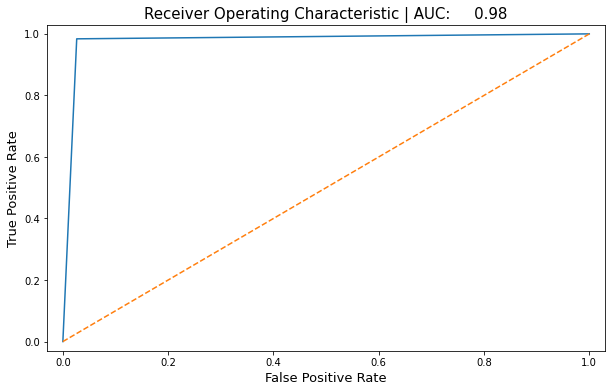

In [34]:
plot_roc(y_test, result_df['prob_1'])

### 19. Suppose you're speaking with the biostatistics lead at Mayo Clinic, who asks you "Why are unbalanced classes generally a problem? Are they a problem in this particular CKD analysis?" How would you respond?

In [35]:
# Ratio of major and minor classes
df['class'].value_counts(normalize=True).mul(100).round(2)

ckd       62.5
notckd    37.5
Name: class, dtype: float64

Answer:

**Why are unbalanced classes generally a problem?**
- Because unbalanced classes lead to insufficient minor class for a model to recognize data pattern. 

**Are they a problem in this particular CKD analysis?**
- There is no problem for unbalanced classes for CKD as CKD and Non-CKD ratio are 62.5% and 37.5% which are not much different.

### 20. Suppose you're speaking with a doctor at Mayo Clinic who, despite being very smart, doesn't know much about data science or statistics. How would you explain why unbalanced classes are generally a problem to this doctor?

Answer:
- Becuse unbalanced classes have huge difference between major and minor classes (e.g. CKD and Non-CKD), the model can learn only majority class pattern and learn too less of minor class pattern. When the model makes prediction, most of the predictions will be majority class.

### 21. Let's create very unbalanced classes just for the sake of this example! Generate very unbalanced classes by [bootstrapping](http://stattrek.com/statistics/dictionary.aspx?definition=sampling_with_replacement) (a.k.a. random sampling with replacement) the majority class.

1. The majority class are those individuals with CKD.
2. Generate a random sample of size 200,000 of individuals who have CKD **with replacement**. (Consider setting a random seed for this part!)
3. Create a new dataframe with the original data plus this random sample of data.
4. Now we should have a dataset with around 200,000 observations, of which only about 0.00075% are non-CKD individuals.

In [36]:
df['class'].value_counts()

ckd       250
notckd    150
Name: class, dtype: int64

In [37]:
# Random 200k data for 'ckd' class with replacement
df_ckd_200 = df[df['class'] == 'ckd'].sample(n=200_000, replace=True, random_state=42)

# Combine new sample with existing sample
df_ckd_200 = pd.concat([df, df_ckd_200], ignore_index=True)

In [38]:
# Check result
df_ckd_200['class'].value_counts(normalize=True).mul(100).round(3)

ckd       99.925
notckd     0.075
Name: class, dtype: float64

### 22. Build a logistic regression model on the unbalanced class data and evaluate its performance using whatever method(s) you see fit. How would you describe the impact of unbalanced classes on logistic regression as a classifier?
> Be sure to look at how well it performs on non-CKD data.

In [39]:
# Set training data

X_200 = df_ckd_200[features]
X_200 = pd.get_dummies(X_200, drop_first=True)

y_200 = (df_ckd_200['class'] == 'ckd').astype(int)

# Split train, test set
X_200_train, X_200_test, y_200_train, y_200_test = train_test_split(X_200, y_200, random_state=42)

In [40]:
# Check split size
X_200_train.shape, X_200_test.shape, y_200_train.shape, y_200_test.shape

((150300, 20), (50100, 20), (150300,), (50100,))

In [41]:
# Check class balance
print(y_200_train.value_counts(normalize=True).mul(100).round(2))
print(y_200_test.value_counts(normalize=True).mul(100).round(2))

1    99.93
0     0.07
Name: class, dtype: float64
1    99.9
0     0.1
Name: class, dtype: float64


In [42]:
# Create model
# Instantiate
logreg2 = LogisticRegression(penalty='none', max_iter=1000, random_state=42)

# Fit model
logreg2.fit(X_200_train, y_200_train)

LogisticRegression(max_iter=1000, penalty='none', random_state=42)

In [43]:
print('Train score:', logreg2.score(X_200_train, y_200_train))
print('Test score:', logreg2.score(X_200_test, y_200_test))

# After oversampling majority class, the model accuracy reach to 99%. 

Train score: 1.0
Test score: 0.9999201596806387


In [44]:
# Print classification report

# predict values for test set
y_200_preds = logreg2.predict(X_200_test)

print(classification_report(y_200_test, y_200_preds))

## The model performance is still doing well after oversampling majority class.
## Specificity is 92%

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        49
           1       1.00      1.00      1.00     50051

    accuracy                           1.00     50100
   macro avg       1.00      0.96      0.98     50100
weighted avg       1.00      1.00      1.00     50100



---

## Step 6: Answer the problem.

At this step, you would generally answer the problem! In this situation, you would likely present your model to doctors or administrators at the hospital and show how your model results in reduced false positives/false negatives. Next steps would be to find a way to roll this model and its conclusions out across the hospital so that the outcomes of patients with CKD (and without CKD!) can be improved!

Answer:
- The model is performe well, Accuracy of the model is 98% which means 98% of model prediction are correct.
- Also, precision and recall are 98%, which means 98% of CKD patient will be found by the model.
- Next step to improve is adjust the model by adjust features or tune the model, so that model can find 100% of CKD patients